<a href="https://colab.research.google.com/github/sydsaenz/18.065FinalProject/blob/main/18_065FinalProjectModel1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from collections import defaultdict
import matplotlib.pyplot as plt

# Data Processing

In [2]:
# mappers of team names to ids and vice versa
url = "https://raw.githubusercontent.com/sydsaenz/18.065FinalProject/main/MTeams.csv"
names_and_ids = pd.read_csv(url)
names_and_ids = names_and_ids[["TeamID", "TeamName"]]
ids_to_names = {}
for i,row in names_and_ids.iterrows():
  ids_to_names[row["TeamID"]] = row["TeamName"]
names_to_ids = {v:k for k,v in ids_to_names.items()}

In [3]:
url = "https://raw.githubusercontent.com/sydsaenz/18.065FinalProject/main/MNCAATourneySeeds.csv"
initial_seeds = pd.read_csv(url)
initial_seeds

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374
...,...,...,...
2621,2025,Z12,1161
2622,2025,Z13,1213
2623,2025,Z14,1423
2624,2025,Z15,1303


In [4]:
# url = "https://raw.githubusercontent.com/sydsaenz/18.065FinalProject/main/MNCAATourneySeedRoundSlots.csv"
# matchings = pd.read_csv(url)
# matchings

In [5]:
#matchings[(matchings["GameRound"]==1) & (matchings["GameSlot"]=="R1W1")]

In [6]:
# team data
url = "https://raw.githubusercontent.com/sydsaenz/18.065FinalProject/main/team_features.csv"
team_data = pd.read_csv(url).drop(columns=["index"])
team_data

,TeamID,Season,seed_num,weighted_past_seed,3pt_success_rate,freethrow_success_rate,field_success_rate
0,1101,1985,17.0,17.00000,0.362112,0.705516,0.432431
1,1101,1986,17.0,17.00000,0.362112,0.705516,0.432431
2,1101,1987,17.0,17.00000,0.362112,0.705516,0.432431
3,1101,1988,17.0,17.00000,0.362112,0.705516,0.432431
4,1101,1989,17.0,17.00000,0.362112,0.705516,0.432431
...,...,...,...,...,...,...,...
12828,1471,2021,17.0,17.00000,0.369792,0.607362,0.459770
12829,1471,2022,17.0,17.00000,0.359636,0.746809,0.437413
12830,1471,2023,17.0,17.00000,0.330128,0.739759,0.431175
12831,1471,2024,17.0,17.00000,0.344733,0.750883,0.448394


In [7]:
# team data exploration
for col in team_data.columns:
  print(col)
  print(team_data[col].describe())
  print(f"n_unique={team_data[col].nunique()}")
  print("------------------------------------------")

TeamID
count    12833.000000
mean      1282.696486
std        103.573835
min       1101.000000
25%       1196.000000
50%       1281.000000
75%       1372.000000
max       1471.000000
Name: TeamID, dtype: float64
n_unique=313
------------------------------------------
Season
count    12833.000000
mean      2005.000000
std         11.832621
min       1985.000000
25%       1995.000000
50%       2005.000000
75%       2015.000000
max       2025.000000
Name: Season, dtype: float64
n_unique=41
------------------------------------------
seed_num
count    12833.000000
mean        15.288865
std          3.975123
min          1.000000
25%         17.000000
50%         17.000000
75%         17.000000
max         17.000000
Name: seed_num, dtype: float64
n_unique=17
------------------------------------------
weighted_past_seed
count    12833.000000
mean        15.266586
std          2.894884
min          1.000000
25%         15.009394
50%         16.623472
75%         16.966853
max         17.000000

In [8]:
for team_id in team_data["TeamID"]:
  if team_id not in ids_to_names:
    print(f"unknown team id: {team_id}")
print(f"number of unique rows: {len(team_data[ ['TeamID', 'Season'] ].drop_duplicates())}")

number of unique rows: 12833


In [9]:
# matches data
url = "https://raw.githubusercontent.com/sydsaenz/18.065FinalProject/main/MNCAATourneyCompactResults.csv"
matches_raw = pd.read_csv(url)
matches_raw

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0
...,...,...,...,...,...,...,...,...
2513,2024,146,1301,76,1181,64,N,0
2514,2024,146,1345,72,1397,66,N,0
2515,2024,152,1163,86,1104,72,N,0
2516,2024,152,1345,63,1301,50,N,0


In [10]:
matches = matches_raw[["Season","WTeamID","LTeamID"]]

In [11]:
# combined winner and loser data for all matches
matches_W = pd.merge(left=matches,right=team_data, left_on=["Season","WTeamID"], right_on=["Season","TeamID"], how="left").drop(columns=["TeamID"])
cols_to_rename = list(set(team_data.columns)-{"Season","TeamID"})
W_names = {n:n+"_W" for n in cols_to_rename}
matches_W.rename(columns=W_names, inplace=True)
matches_WL = pd.merge(left=matches_W,right=team_data, left_on=["Season","LTeamID"], right_on=["Season","TeamID"], how="left").drop(columns=["TeamID"])
L_names = {n:n+"_L" for n in cols_to_rename}
matches_WL.rename(columns=L_names, inplace=True)
matches_WL

,Season,WTeamID,LTeamID,seed_num_W,weighted_past_seed_W,3pt_success_rate_W,freethrow_success_rate_W,field_success_rate_W,seed_num_L,weighted_past_seed_L,3pt_success_rate_L,freethrow_success_rate_L,field_success_rate_L
0,1985,1116,1234,9.0,9.000000,0.337744,0.669443,0.437813,8.0,8.000000,0.345894,0.704658,0.447840
1,1985,1120,1345,11.0,11.000000,0.344374,0.663121,0.443238,6.0,6.000000,0.329985,0.707424,0.439642
2,1985,1207,1250,1.0,1.000000,0.351575,0.714259,0.453702,16.0,16.000000,0.346186,0.708815,0.412565
3,1985,1229,1425,9.0,9.000000,0.367681,0.661989,0.439417,8.0,8.000000,0.349069,0.671232,0.440966
4,1985,1242,1325,3.0,3.000000,0.361299,0.678938,0.477377,14.0,14.000000,0.345948,0.703845,0.444500
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,1301,1181,11.0,13.237115,0.346049,0.733520,0.449203,4.0,3.647542,0.377119,0.721875,0.481794
2514,2024,1345,1397,1.0,7.671132,0.408012,0.721212,0.488324,2.0,10.931864,0.341912,0.749263,0.444332
2515,2024,1163,1104,1.0,9.102944,0.366871,0.742470,0.495988,4.0,11.536523,0.365325,0.783562,0.477317
2516,2024,1345,1301,1.0,7.671132,0.408012,0.721212,0.488324,11.0,13.237115,0.346049,0.733520,0.449203


In [12]:
# add column for winner - loser difference
for col in cols_to_rename:
  matches_WL[col+"_diff"] = matches_WL[col+"_W"] - matches_WL[col+"_L"]
matches_WL

,Season,WTeamID,LTeamID,seed_num_W,weighted_past_seed_W,3pt_success_rate_W,freethrow_success_rate_W,field_success_rate_W,seed_num_L,weighted_past_seed_L,3pt_success_rate_L,freethrow_success_rate_L,field_success_rate_L,seed_num_diff,field_success_rate_diff,freethrow_success_rate_diff,weighted_past_seed_diff,3pt_success_rate_diff
0,1985,1116,1234,9.0,9.000000,0.337744,0.669443,0.437813,8.0,8.000000,0.345894,0.704658,0.447840,1.0,-0.010027,-0.035215,1.000000,-0.008150
1,1985,1120,1345,11.0,11.000000,0.344374,0.663121,0.443238,6.0,6.000000,0.329985,0.707424,0.439642,5.0,0.003596,-0.044302,5.000000,0.014389
2,1985,1207,1250,1.0,1.000000,0.351575,0.714259,0.453702,16.0,16.000000,0.346186,0.708815,0.412565,-15.0,0.041138,0.005444,-15.000000,0.005389
3,1985,1229,1425,9.0,9.000000,0.367681,0.661989,0.439417,8.0,8.000000,0.349069,0.671232,0.440966,1.0,-0.001549,-0.009242,1.000000,0.018613
4,1985,1242,1325,3.0,3.000000,0.361299,0.678938,0.477377,14.0,14.000000,0.345948,0.703845,0.444500,-11.0,0.032877,-0.024906,-11.000000,0.015352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2513,2024,1301,1181,11.0,13.237115,0.346049,0.733520,0.449203,4.0,3.647542,0.377119,0.721875,0.481794,7.0,-0.032591,0.011645,9.589573,-0.031070
2514,2024,1345,1397,1.0,7.671132,0.408012,0.721212,0.488324,2.0,10.931864,0.341912,0.749263,0.444332,-1.0,0.043992,-0.028050,-3.260732,0.066100
2515,2024,1163,1104,1.0,9.102944,0.366871,0.742470,0.495988,4.0,11.536523,0.365325,0.783562,0.477317,-3.0,0.018671,-0.041092,-2.433579,0.001546
2516,2024,1345,1301,1.0,7.671132,0.408012,0.721212,0.488324,11.0,13.237115,0.346049,0.733520,0.449203,-10.0,0.039121,-0.012308,-5.565984,0.061963


In [13]:
# label these as 1 (team1 wins)
matches_diff = matches_WL[[col for col in matches_WL.columns if "diff" in col]]
matches_diff["team_1_win"] = 1
matches_diff

<ipython-input-13-b3a1ec68b102>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_diff["team_1_win"] = 1


,seed_num_diff,field_success_rate_diff,freethrow_success_rate_diff,weighted_past_seed_diff,3pt_success_rate_diff,team_1_win
0,1.0,-0.010027,-0.035215,1.000000,-0.008150,1
1,5.0,0.003596,-0.044302,5.000000,0.014389,1
2,-15.0,0.041138,0.005444,-15.000000,0.005389,1
3,1.0,-0.001549,-0.009242,1.000000,0.018613,1
4,-11.0,0.032877,-0.024906,-11.000000,0.015352,1
...,...,...,...,...,...,...
2513,7.0,-0.032591,0.011645,9.589573,-0.031070,1
2514,-1.0,0.043992,-0.028050,-3.260732,0.066100,1
2515,-3.0,0.018671,-0.041092,-2.433579,0.001546,1
2516,-10.0,0.039121,-0.012308,-5.565984,0.061963,1


In [14]:
# negate copy of this dataframe so it's loser-winner. label with 0 (team1 loses)
matches_diff_negated = matches_diff.copy()
# adding 10000 to the index so they are unique but also so i can find the corresponding pair easily
matches_diff_negated.index = matches_diff.index+ np.ones_like(matches_diff.index)*10000
matches_diff_negated = -matches_diff_negated
matches_diff_negated["team_1_win"] = 0
matches_diff_negated

,seed_num_diff,field_success_rate_diff,freethrow_success_rate_diff,weighted_past_seed_diff,3pt_success_rate_diff,team_1_win
10000,-1.0,0.010027,0.035215,-1.000000,0.008150,0
10001,-5.0,-0.003596,0.044302,-5.000000,-0.014389,0
10002,15.0,-0.041138,-0.005444,15.000000,-0.005389,0
10003,-1.0,0.001549,0.009242,-1.000000,-0.018613,0
10004,11.0,-0.032877,0.024906,11.000000,-0.015352,0
...,...,...,...,...,...,...
12513,-7.0,0.032591,-0.011645,-9.589573,0.031070,0
12514,1.0,-0.043992,0.028050,3.260732,-0.066100,0
12515,3.0,-0.018671,0.041092,2.433579,-0.001546,0
12516,10.0,-0.039121,0.012308,5.565984,-0.061963,0


In [15]:
# concatenate W-L and L-W to get training dataset
model_dataset = pd.concat([matches_diff, matches_diff_negated])
model_dataset

,seed_num_diff,field_success_rate_diff,freethrow_success_rate_diff,weighted_past_seed_diff,3pt_success_rate_diff,team_1_win
0,1.0,-0.010027,-0.035215,1.000000,-0.008150,1
1,5.0,0.003596,-0.044302,5.000000,0.014389,1
2,-15.0,0.041138,0.005444,-15.000000,0.005389,1
3,1.0,-0.001549,-0.009242,1.000000,0.018613,1
4,-11.0,0.032877,-0.024906,-11.000000,0.015352,1
...,...,...,...,...,...,...
12513,-7.0,0.032591,-0.011645,-9.589573,0.031070,0
12514,1.0,-0.043992,0.028050,3.260732,-0.066100,0
12515,3.0,-0.018671,0.041092,2.433579,-0.001546,0
12516,10.0,-0.039121,0.012308,5.565984,-0.061963,0


In [16]:
# evaluate logisitic regression as a predictor
X = model_dataset.drop('team_1_win', axis=1)
y = model_dataset['team_1_win']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_train = logreg.predict(X_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

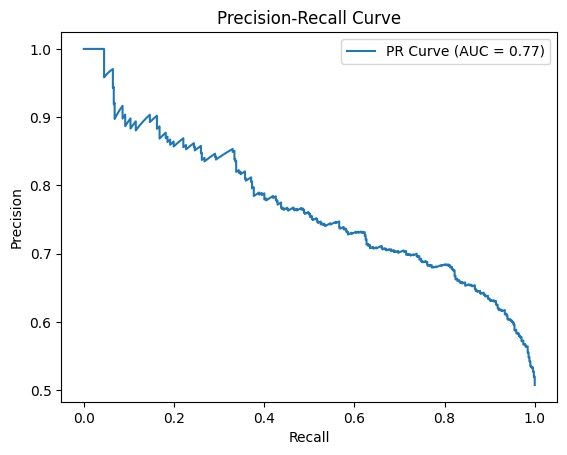

In [17]:
# precision recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.plot(recall, precision, label=f'PR Curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


In [18]:
test_accuracy = accuracy_score(y_test, y_pred)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"{test_accuracy=}        {train_accuracy=}")

test_precision = precision_score(y_test, y_pred)
train_precision = precision_score(y_train, y_pred_train)
print(f"{test_precision=}        {train_precision=}")


test_recall = recall_score(y_test, y_pred)
train_recall = recall_score(y_train, y_pred_train)
print(f"{test_recall=}        {train_recall=}")


test_f1 = f1_score(y_test, y_pred)
train_f1 = f1_score(y_train, y_pred_train)
print(f"{test_f1=}        {train_f1=}")

test_accuracy=0.6984126984126984        train_accuracy=0.7149950347567031
test_precision=0.6984732824427481        train_precision=0.7140718562874252
test_recall=0.71484375        train_recall=0.7133599202392822
test_f1=0.7065637065637066        train_f1=0.7137157107231921


In [19]:
# confusion matrices
test_conf_matrix = confusion_matrix(y_test, y_pred)
train_conf_matrix = confusion_matrix(y_train, y_pred_train)

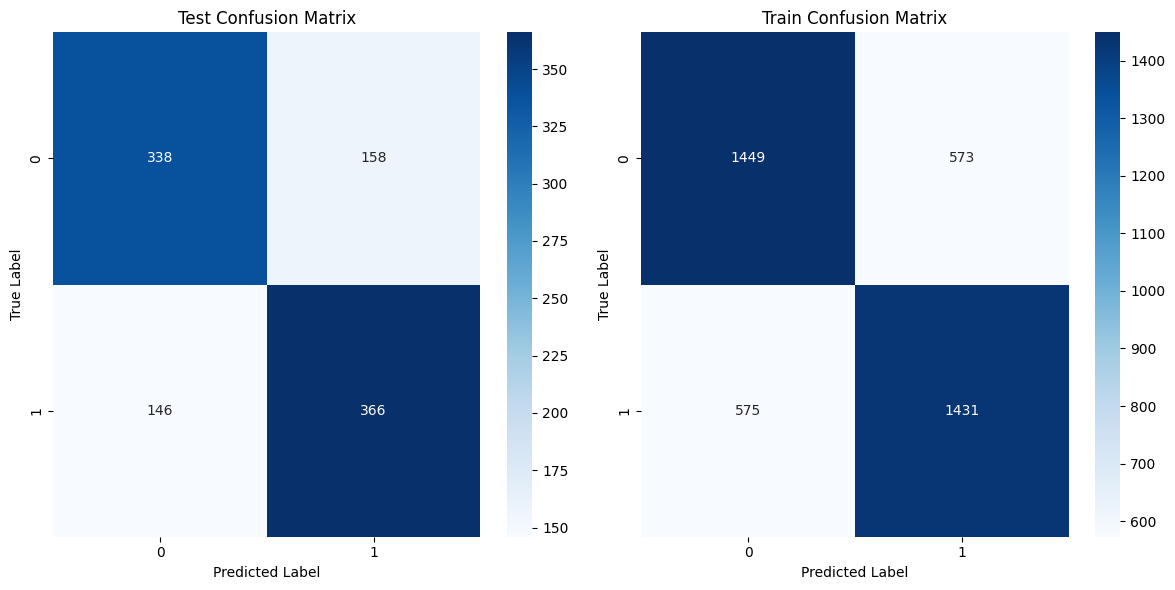

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.heatmap(test_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[0])
axes[0].set_title("Test Confusion Matrix")
axes[0].set_xlabel("Predicted Label")
axes[0].set_ylabel("True Label")

sns.heatmap(train_conf_matrix, annot=True, fmt="d", cmap="Blues", ax=axes[1])
axes[1].set_title("Train Confusion Matrix")
axes[1].set_xlabel("Predicted Label")
axes[1].set_ylabel("True Label")

plt.tight_layout()
plt.show()

In [21]:
logreg_full = LogisticRegression(max_iter=1000) # Increased max_iter for convergence
logreg_full.fit(X, y)

LogisticRegression(max_iter=1000)

In [39]:
coefficients = logreg_full.coef_
intercept = logreg_full.intercept_

print("Coefficients:")
for f,c in zip(list(X.columns), coefficients.tolist()[0]):
  print(f"{f}: {c}")

print("Intercept:", intercept[0])

Coefficients:
seed_num_diff: -0.12869193117993863
field_success_rate_diff: 1.8300851036576593
freethrow_success_rate_diff: 1.1663690062994188
weighted_past_seed_diff: -0.04835181760235699
3pt_success_rate_diff: -0.14111033400023376
Intercept: 5.024365260680484e-10




---

# MCMC Bracket Simulator


In [ ]:
class Team(): # data structure for node
  def __init__(self, team_id=None, team_name=None):

    if (team_id is None) and (team_name is None):
      raise ValueError("must provide at least one of team name or team id")
    if team_id is None:
      team_id = names_to_ids[team_name]
    if team_name is None:
      team_name = ids_to_names[team_id]

    self.id = team_id
    self.name = team_name
    self.prev_games = []

class Game(): # node for tree
  def __init__(self, team1, team2):
        self.team1 = team1
        self.team2 = team2
        self.team1_prev_game = team1.prev_games[-1] if team1.prev_games else None
        self.team2_prev_game = team2.prev_games[-1] if team2.prev_games else None
        self.winner = None
        self.winner_next_game = None # don't use this yet idk how

In [ ]:
class Game_simulator():
  def __init__(self, model,team_stats):
    self.model = model # logreg
    self.team_stats = team_stats # df, index is team id

  def get_prob_team1_win(self, team1,team2):
    data = self.team_stats.loc[team1.id,:] - self.team_stats.loc[team2.id,:]
    data = pd.DataFrame(data).T
    data.rename(columns={c:c+"_diff" for c in data.columns},inplace=True)
    data = data[X.columns]
    #print(data)
    prob = self.model.predict_proba(data)
    #print(prob.shape)
    return prob[0,1] # probability of class 1 (team 1 wins)

  def play(self, game):
    game.team1.prev_games.append(game) # only after play is called is game added to prev games. not when game is created
    game.team2.prev_games.append(game)
    prob_team_1_wins = self.get_prob_team1_win( game.team1, game.team2)
    if np.random.rand() < prob_team_1_wins:
      game.winner = game.team1
    else:
      game.winner = game.team2

In [ ]:
def get_initial_seeds_pairs(year):
  df = initial_seeds[initial_seeds["Season"] == year]
  pairs = []
  for i,row in df.iterrows():
    pairs.append((Team(team_id=row["TeamID"]),row["Seed"]))
  return pairs

In [ ]:
class Bracket_simulation():
  def __init__(self, team_data_all_years, year, model, ids_to_names):
    self.region_names = ["W", "X", "Y", "Z"]
    self.team_data = team_data_all_years[team_data_all_years["Season"] == year].set_index("TeamID").drop(columns=["Season"])
    self.initial_seeds= get_initial_seeds_pairs(year) # list of (team_id,seed) pairs
    self.game_simulator = Game_simulator(model, self.team_data)
    self.first_four_matches = []
    self.regional_matches = {}

  def run_first_four(self, verbose=True):
    first_round = []
    for i in range(len(self.initial_seeds)-1,-1,-1):
      t = self.initial_seeds[i]
      if ((t[1][-1]=="a") or (t[1][-1]=="b")): # first round
        first_round.append(self.initial_seeds.pop(i))
    first_round.sort(key=lambda x:x[1] )

    if verbose:
      print("Running first four:")

    while first_round:
      t1 = first_round.pop(0)
      t2 = first_round.pop(0)
      team1 = t1[0]
      team2 = t2[0]
      game = Game(team1,team2)
      self.game_simulator.play(game)
      self.first_four_matches.append(game)
      self.initial_seeds.append( ( game.winner, t1[1][:3] ) ) #add the winner to the initial seeds without the extra letter a or b

      if verbose:
        print(f"- {team1.name} played {team2.name} and {game.winner.name} won.")

    if verbose:
      print("----------------------------------------------------------------")

  def run_region(self, region_letter, verbose=True):
    seeds = self.region_initial_seeds[region_letter]

    # level 1
    if verbose:
      print(f"Running level 1 of region {region_letter}")

    level_1 = []

    game = Game(seeds[1],seeds[16])
    self.game_simulator.play(game)
    seeds[17] = game.winner # these seed numbers (17+) don't mean anything, it's so i can find who needs to play who
    level_1.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[8],seeds[9])
    self.game_simulator.play(game)
    seeds[18] = game.winner
    level_1.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[5],seeds[12])
    self.game_simulator.play(game)
    seeds[19] = game.winner
    level_1.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[4],seeds[13])
    self.game_simulator.play(game)
    seeds[20] = game.winner
    level_1.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[6],seeds[11])
    self.game_simulator.play(game)
    seeds[21] = game.winner
    level_1.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")


    game = Game(seeds[3],seeds[14])
    self.game_simulator.play(game)
    seeds[22] = game.winner
    level_1.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[7],seeds[10])
    self.game_simulator.play(game)
    seeds[23] = game.winner
    level_1.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[2],seeds[15])
    self.game_simulator.play(game)
    seeds[24] = game.winner
    level_1.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    # level 2
    if verbose:
      print(" ")
      print(f"Running level 2 of region {region_letter}")

    level_2 = []

    game = Game(seeds[17],seeds[18])
    self.game_simulator.play(game)
    seeds[25] = game.winner
    level_2.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[19],seeds[20])
    self.game_simulator.play(game)
    seeds[26] = game.winner
    level_2.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[21],seeds[22])
    self.game_simulator.play(game)
    seeds[27] = game.winner
    level_2.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[23],seeds[24])
    self.game_simulator.play(game)
    seeds[28] = game.winner
    level_2.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    # level 3
    if verbose:
      print(" ")
      print(f"Running level 3 (regional quarter final) of region {region_letter}")

    level_3 = []
    game = Game(seeds[25],seeds[26])
    self.game_simulator.play(game)
    seeds[29] = game.winner
    level_3.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(seeds[27],seeds[28])
    self.game_simulator.play(game)
    seeds[30] = game.winner
    level_3.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    # level 4 (regional final)
    if verbose:
      print(" ")
      print(f"Running level 4 (regional final) of region {region_letter}")

    level_4 = []
    game = Game(seeds[29],seeds[30])
    self.game_simulator.play(game)
    seeds[31] = game.winner
    level_4.append(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")
      print(f"{game.winner.name} is the regional winner!")
      print("------------------------------------------------------------------")

    self.regional_matches[region_letter] = {
        "level1": level_1,
        "level2": level_2,
        "level3": level_3,
        "level4": level_4,
        "winner": game.winner
    }

  def run_semi_and_final(self, verbose=True):
    if verbose:
      final4 = [self.regional_matches[r]["winner"].name for r in self.region_names ]
      print(f"The final 4 are {final4}.")

    # region W plays X
    # region Y plays Z

    # semi
    semis = {}
    if verbose:
      print("Running semi finals:")

    game = Game(self.regional_matches["W"]["winner"], self.regional_matches["X"]["winner"] )
    self.game_simulator.play(game)
    semis["WX"] = game
    wx_winner = game.winner
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    game = Game(self.regional_matches["Y"]["winner"], self.regional_matches["Z"]["winner"] )
    self.game_simulator.play(game)
    semis["YZ"] = game
    yz_winner = game.winner
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")

    # final
    if verbose:
      print(" ")
      print("Running final:")

    game = Game(wx_winner,yz_winner)
    self.game_simulator.play(game)
    if verbose:
      print(f"{game.team1.name} played {game.team2.name} and {game.winner.name} won.")
      print(f"The winner is {game.winner.name}!")
      print("==================================================================")

    self.semis = semis
    self.final = game



  def run_tournament(self, verbose=True):
    self.run_first_four(verbose=verbose)

    #self.region_initial_seeds = {"W": {}, "X": {}, "Y": {}, "Z": {} }
    self.region_initial_seeds = {r: {} for r in self.region_names }
    for t in self.initial_seeds:
      self.region_initial_seeds[t[1][0]] [int(t[1][1:])] = t[0]

    for region_letter in  self.region_names:
      self.run_region(region_letter,verbose=verbose)

    self.run_semi_and_final(verbose=verbose)





In [ ]:
# example
my_bracket = Bracket_simulation(team_data, 2025, logreg_full, ids_to_names)
my_bracket.run_tournament(verbose=True)

Running first four:
- American Univ played Mt St Mary's and Mt St Mary's won.
- Texas played Xavier and Xavier won.
- North Carolina played San Diego St and North Carolina won.
- Alabama St played St Francis PA and St Francis PA won.
----------------------------------------------------------------
Running level 1 of region W
Duke played Mt St Mary's and Duke won.
Mississippi St played Baylor and Mississippi St won.
Oregon played Liberty and Oregon won.
Arizona played Akron and Akron won.
BYU played VCU and VCU won.
Wisconsin played Montana and Montana won.
St Mary's CA played Vanderbilt and Vanderbilt won.
Alabama played Robert Morris and Alabama won.
 
Running level 2 of region W
Duke played Mississippi St and Duke won.
Oregon played Akron and Oregon won.
VCU played Montana and Montana won.
Vanderbilt played Alabama and Alabama won.
 
Running level 3 (regional quarter final) of region W
Duke played Oregon and Duke won.
Montana played Alabama and Alabama won.
 
Running level 4 (regiona

In [ ]:
iters = 10000
winner_counts = defaultdict(int)
made_final_4_counts = defaultdict(int) #

for i in range(iters):
  bracket = Bracket_simulation(team_data, 2025, logreg_full, ids_to_names)
  bracket.run_tournament(verbose=False)
  winner = bracket.final.winner.name
  winner_counts[winner] += 1
  final4 = [ bracket.semis["WX"].team1.name, bracket.semis["WX"].team2.name,  bracket.semis["YZ"].team1.name,  bracket.semis["YZ"].team2.name  ] #
  for team in final4: #
    made_final_4_counts[team] += 1 #

  if i%500 == 0: #
    print(f"{i+1}/{iters} complete") #


1/10000 complete
501/10000 complete
1001/10000 complete
1501/10000 complete
2001/10000 complete
2501/10000 complete
3001/10000 complete
3501/10000 complete
4001/10000 complete
4501/10000 complete
5001/10000 complete
5501/10000 complete
6001/10000 complete
6501/10000 complete
7001/10000 complete
7501/10000 complete
8001/10000 complete
8501/10000 complete
9001/10000 complete
9501/10000 complete


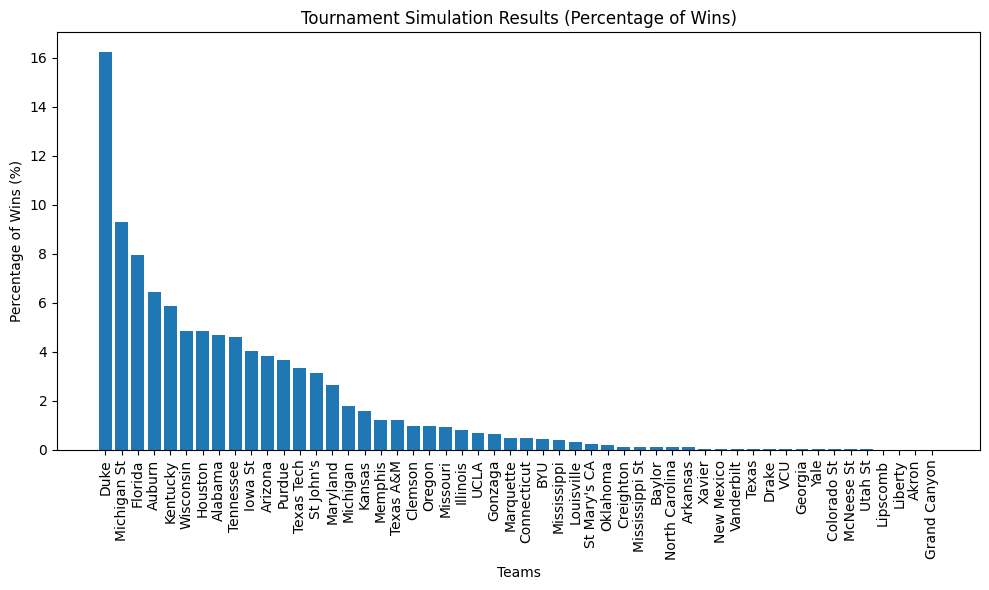

In [ ]:
# prompt: make a bar plot with winner_counts. sort the teams in decreasing number of wins. make it a percentage of wins


# Assuming winner_counts is already populated from the previous code

# Sort teams by decreasing number of wins
sorted_winners = dict(sorted(winner_counts.items(), key=lambda item: item[1], reverse=True))

# Calculate percentages
total_iterations = sum(winner_counts.values())
percentages = {team: (count / total_iterations) * 100 for team, count in sorted_winners.items()}

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(percentages.keys(), percentages.values())
plt.xlabel("Teams")
plt.ylabel("Percentage of Wins (%)")
plt.title("Tournament Simulation Results (Percentage of Wins)")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


In [ ]:
for t,f in sorted_winners.items():
  print(f"{t}: {f} or {(f/10000)*100}%")

Duke: 1623 or 16.23%
Michigan St: 930 or 9.3%
Florida: 796 or 7.960000000000001%
Auburn: 645 or 6.45%
Kentucky: 586 or 5.86%
Wisconsin: 487 or 4.87%
Houston: 486 or 4.859999999999999%
Alabama: 469 or 4.6899999999999995%
Tennessee: 461 or 4.61%
Iowa St: 402 or 4.02%
Arizona: 385 or 3.85%
Purdue: 369 or 3.6900000000000004%
Texas Tech: 335 or 3.35%
St John's: 314 or 3.1399999999999997%
Maryland: 265 or 2.65%
Michigan: 180 or 1.7999999999999998%
Kansas: 158 or 1.58%
Memphis: 124 or 1.24%
Texas A&M: 121 or 1.21%
Clemson: 97 or 0.97%
Oregon: 96 or 0.96%
Missouri: 94 or 0.9400000000000001%
Illinois: 80 or 0.8%
UCLA: 69 or 0.69%
Gonzaga: 66 or 0.66%
Marquette: 49 or 0.49%
Connecticut: 47 or 0.47000000000000003%
BYU: 45 or 0.44999999999999996%
Mississippi: 39 or 0.38999999999999996%
Louisville: 34 or 0.33999999999999997%
St Mary's CA: 25 or 0.25%
Oklahoma: 20 or 0.2%
Creighton: 14 or 0.13999999999999999%
Mississippi St: 14 or 0.13999999999999999%
Baylor: 13 or 0.13%
North Carolina: 12 or 0.12%


In [ ]:
# iters = 10000
# made_final_4_counts = defaultdict(int)

# for i in range(iters):
#   bracket = Bracket_simulation(team_data, 2025, logreg_full, ids_to_names)
#   bracket.run_tournament(verbose=False)
#   final4 = [ bracket.semis["WX"].team1.name, bracket.semis["WX"].team2.name,  bracket.semis["YZ"].team1.name,  bracket.semis["YZ"].team2.name  ]
#   for team in final4:
#     made_final_4_counts[team] += 1

#   if i%500 == 0:
#     print(f"{i+1}/{iters} complete")


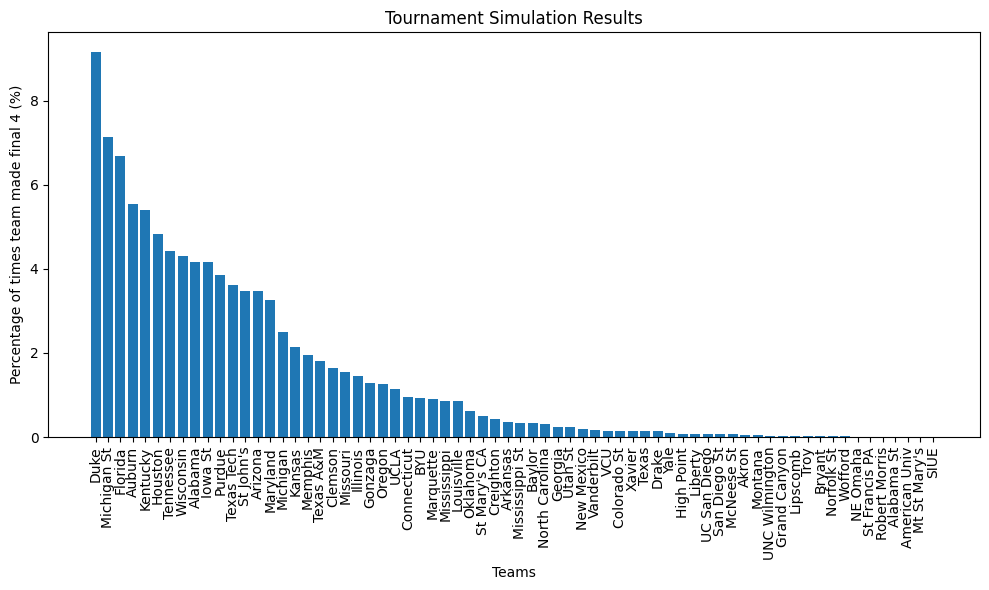

In [ ]:
# Sort teams by decreasing number of wins
sorted_final4_counts = dict(sorted(made_final_4_counts.items(), key=lambda item: item[1], reverse=True))

# Calculate percentages
total_iterations = sum(made_final_4_counts.values())
percentages = {team: (count / total_iterations) * 100 for team, count in sorted_final4_counts.items()}

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(percentages.keys(), percentages.values())
plt.xlabel("Teams")
plt.ylabel("Percentage of times team made final 4 (%)")
plt.title("Tournament Simulation Results")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
for t,f in sorted_final4_counts.items():
  print(f"{t}: {f} or {(f/10000)*100}%")

Duke: 3666 or 36.66%
Michigan St: 2852 or 28.52%
Florida: 2674 or 26.740000000000002%
Auburn: 2218 or 22.18%
Kentucky: 2156 or 21.560000000000002%
Houston: 1932 or 19.32%
Tennessee: 1773 or 17.73%
Wisconsin: 1726 or 17.26%
Alabama: 1667 or 16.669999999999998%
Iowa St: 1666 or 16.66%
Purdue: 1541 or 15.409999999999998%
Texas Tech: 1448 or 14.48%
St John's: 1390 or 13.900000000000002%
Arizona: 1390 or 13.900000000000002%
Maryland: 1302 or 13.020000000000001%
Michigan: 999 or 9.99%
Kansas: 856 or 8.559999999999999%
Memphis: 780 or 7.8%
Texas A&M: 725 or 7.249999999999999%
Clemson: 653 or 6.529999999999999%
Missouri: 623 or 6.23%
Illinois: 585 or 5.8500000000000005%
Gonzaga: 516 or 5.16%
Oregon: 506 or 5.06%
UCLA: 460 or 4.6%
Connecticut: 382 or 3.82%
BYU: 372 or 3.7199999999999998%
Marquette: 359 or 3.5900000000000003%
Mississippi: 346 or 3.46%
Louisville: 343 or 3.4299999999999997%
Oklahoma: 250 or 2.5%
St Mary's CA: 202 or 2.02%
Creighton: 173 or 1.73%
Arkansas: 141 or 1.41%
Mississippi